# Expected Scattering if laser beam was traveling to the camera's right

In [1]:
# Mount Google Drive
from google.colab import drive # import drive from google colab

ROOT = "/content/drive"     # default location for the drive
print(ROOT)                 # print content of ROOT (Optional)

drive.mount(ROOT)           # we mount the google drive at /content/drive

/content/drive
Mounted at /content/drive


In [ ]:
%pwd

'/content'

In [2]:
%cd drive/MyDrive/QLI_Lab_Project/sim_img_demo

/content/drive/MyDrive/QLI_Lab_Project/sim_img_demo


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

data = pd.read_excel('mieplot_disperse_data.xlsx') # Data collected from Mieplot
data

,Angle theta,Perpendicular Watts/sq. m.,Parallel Watts/sq. m.,Unpolarised Watts/sq. m.
0,0.0,4.920796e-07,4.920796e-07,4.920796e-07
1,0.1,4.845073e-07,4.845192e-07,4.845132e-07
2,0.2,4.624239e-07,4.624696e-07,4.624467e-07
3,0.3,4.276502e-07,4.277458e-07,4.276980e-07
4,0.4,3.829691e-07,3.831226e-07,3.830458e-07
...,...,...,...,...
1796,179.6,3.128089e-11,2.088738e-11,2.608413e-11
1797,179.7,3.305230e-11,2.624071e-11,2.964650e-11
1798,179.8,3.462976e-11,3.126478e-11,3.294727e-11
1799,179.9,3.572000e-11,3.482477e-11,3.527239e-11


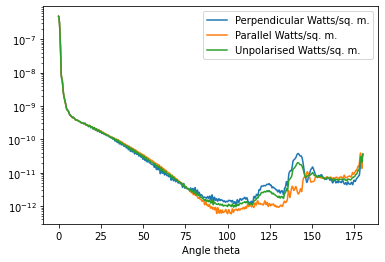

In [ ]:
data.plot('Angle theta', ['Perpendicular Watts/sq. m.', 'Parallel Watts/sq. m.', 'Unpolarised Watts/sq. m.'], logy=True)



In [4]:
def get_expected_scattering(R, theta_L, theta_range, polarized):
    """
    Parameters:
    -----
        - float R: the normal distance (in meters) between the camera and laser beam in meters. 
        On the lab table, R ∈ (0, 1.83)
        - float theta_L: angle between laser beam and imaging plane of camera (in degrees, rounded to one decimal)
        - tuple theta_range: range of angles (in degrees) the camera can view. Let 90º be perpendicular to the imaging plane.
        - string polarized: whether we want the intensity of perpendicular polarized light, 
        parallel polarized light, or unpolarized light
    Output:
    -----
        - a DataFrame aka a data table. See the csv file in the github repo to see a sample output.
    """
    theta_L = round(theta_L, 1)
    theta_min = theta_range[0]
    theta_max = theta_range[1]
    data = pd.read_excel('mieplot_disperse_data.xlsx') # converts excel file to a DataFrame object
    data = data[['Angle theta', polarized]] # select two columns from the file
    if theta_L >= 0 and theta_L < 90:
        # Camera will see scattered light coming from theta aka "camera's theta"
        # The intensity of this light corresponds to intensity of light according to mieplot 
        # when angle_theta = 180 - "camera's theta" + theta_L
        # therefore, camera's theta = 180 + theta_L - angle_theta
        data.insert(0, "Camera's theta", 180 + theta_L - data['Angle theta'])
        inverse_l = (np.sin(np.deg2rad(data["Camera's theta"] - theta_L)) 
                    / (R * np.sin(np.deg2rad(theta_L + 90))))
        # ^ inverse_l is an array holding the inverse of the distances between the camera lens focal point 
        # and every particle
        data[polarized] = (data[polarized] * inverse_l ** 2)
        # changes the intensities of the light based on the varying distances between the camera and scattered light
        data[polarized] = data[polarized] / np.sin(np.deg2rad(data["Camera's theta"] - theta_L))
        # ^ Accounts for the thickness of the laser i.e. it changes the intensities of scattered rays of light 
        # based on the thickness of the laser at the angle of the scattered ray
    elif theta_L >= 90 and theta_L <= 180:
        # Camera will see scattered light coming from theta aka "camera's theta"
        # The intensity of this light corresponds to intensity of light according to mieplot 
        # when angle_theta = theta_L - "camera's theta"
        # therefore, camera's theta = theta_L - angle_theta
        data.insert(0, "Camera's theta", theta_L - data['Angle theta'])
        inverse_l = (np.sin(np.deg2rad(theta_L - data["Camera's theta"])) 
                    / (R * np.sin(np.deg2rad(270 - theta_L)))) 
        # ^ inverse_l is an array holding the inverse of the distances between the camera lens focal point 
        # and every particle
        data[polarized] = (data[polarized] * inverse_l ** 2)
        # changed the intensities of the light based on the varying distances between the camera and scattered light
        data[polarized] = data[polarized] / np.sin(np.deg2rad(theta_L - data["Camera's theta"]))
        # ^ Accounts for the thickness of the laser i.e. it changes the intensities of scattered rays of light 
        # based on the thickness of the laser at the angle of the scattered ray
    else:
        print("theta_L must be between 0 and 180")
    data = data[np.logical_and(data["Camera's theta"] >= theta_min, data["Camera's theta"] <= theta_max)]
    # Keeps all the data points when camera's theta is within camera's field of view
    """Quantalux camera parameters."""
    sensor_width = 9.677 # mm 
    resolution_h = 1920 # pixels 
    focal_length = 16 + 4.94 # mm. we have a spacer that's 4.94 mm long. Camera lens as focal length of 16 mm.
    # we are focusing the camera lens at infinity, so focal_length ≈ 16mm + 4.94mm
    r = focal_length * np.tan(np.deg2rad(data["Camera's theta"] - 90)) 
    # ^ horizontal position (mm) of origin of scattered light on the sensor
    data.insert(0, "Horizontal sensor pos", r)
    
    ############################
    # print(data)
    # print("---------------")
    # some of the light doesn't fall on the sensor, so we must make their light intensity data NaN (not a number).
    # We don't remove the data so that we can still see all the Camera angles and Angle Theta's in the DataFrame 
    data["Horizontal sensor pos"][abs(data["Horizontal sensor pos"]) >= sensor_width / 2] = np.nan
    # print(data[800:900])
    ############################
    
    h = np.round(-resolution_h / sensor_width * data["Horizontal sensor pos"] + resolution_h / 2).astype('Int16')
    # ^ horizontal pixel position of origin of scattered light on the sensor 
    # ^ our image is the reverse of what is on the sensor, which is why there's a negative sign
    data.insert(0, "Horizontal pixel pos", h)
    return data
    
def show_simulated_image(data, theta_L, width_of_laser_in_pixels=400, resolution=(1920, 1080), sensor_width=9.677):
    """
    Parameters:
    -----
        - DataFrame data: containing at least two columns, one of which contains info about the horizontal 
          pixel location, the other contains info about the light intensity at that horizontal pixel location
        - int width_of_laser_in_pixels: tells the width of the laser in pixels for good viewing experience
        - tuple resolution: tells resolution of camera's sensor
        - float sensor_width: the horizontal length of the sensor in mm
    
    Output:
    -----
    Plots a grayscale simulated image
    """
    resolution_w, resolution_h = resolution
    img = np.zeros((resolution_h, resolution_w))
    height_min = int(resolution_h / 2 - width_of_laser_in_pixels / 2) 
    height_max = int(resolution_h / 2 + width_of_laser_in_pixels / 2)
    # set the min and max height of laser shown on image
    laser = np.zeros((resolution_w,))
    polarized = data.columns[-1] # gets name of last column in data. last column contains intensity data
    data = data[abs(data["Horizontal sensor pos"]) <= sensor_width / 2]
    laser[data["Horizontal pixel pos"].astype(int)] = data[polarized]
    # ^ Creates np.array from data which has 
    # a column holding values of the array's indices and another column holding the value at each index
    img[height_min:height_max] = laser * width_of_laser_in_pixels # set the laser to be a certain width
    
    plt.figure(figsize=(10, 6), dpi=80) # set figsize of the plot
    ax = plt.gca()
    img = ax.imshow(img, cmap='gray')
    plt.xlabel('Simulated image for when theta_L=' + str(theta_L) + "º")

    # create an axes on the right side of ax. The width of cax will be 5%
    # of ax and the padding between cax and ax will be fixed at 0.05 inch.
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)  
    plt.colorbar(img, cax=cax)
    
    
def get_simulated_image(data, width_of_laser_in_pixels=400, resolution=(1920, 1080), sensor_width=9.677):
    """
    Parameters:
    -----
        - DataFrame data: containing at least two columns, one of which contains info about the horizontal 
          pixel location, the other contains info about the light intensity at that horizontal pixel location
        - int width_of_laser_in_pixels: tells the width of the laser in pixels for good viewing experience
        - tuple resolution: tells resolution of camera's sensor
        - float sensor_width: the horizontal length of the sensor in mm
    
    Output:
    -----
    The numpy array of a simulated grayscale image
    """
    resolution_w, resolution_h = resolution
    img = np.zeros((resolution_h, resolution_w))
    height_min = int(resolution_h / 2 - width_of_laser_in_pixels / 2) 
    height_max = int(resolution_h / 2 + width_of_laser_in_pixels / 2)
    # set the min and max height of laser shown on image
    laser = np.zeros((resolution_w,))
    polarized = data.columns[-1] # gets name of last column in data. last column contains intensity data
    data = data[abs(data["Horizontal sensor pos"]) <= sensor_width / 2]
    laser[data["Horizontal pixel pos"].astype(int)] = data[polarized]
    # ^ Creates np.array from data which has
    # a column holding values of the array's indices and another column holding the value at each index
    img[height_min:height_max] = laser * width_of_laser_in_pixels # set the laser to be a certain width
    return img

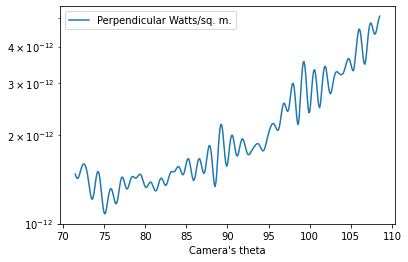

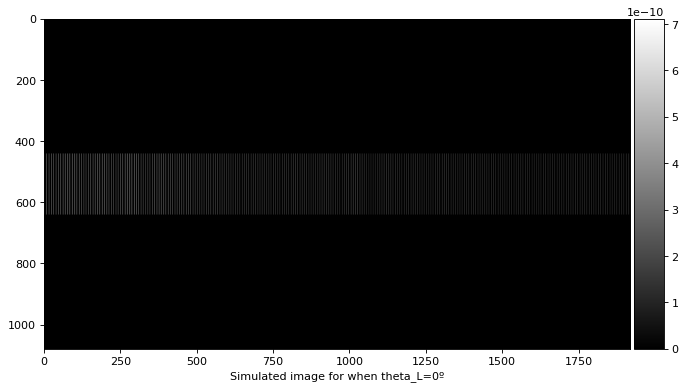

In [5]:
from collections import namedtuple
polarized_options = namedtuple('polarizer', ['s', 'p', 'none'])
polarizer = polarized_options('Perpendicular Watts/sq. m.', 'Parallel Watts/sq. m.', 'Unpolarised Watts/sq. m.')
theta_L = 0
expected_scattering = get_expected_scattering(R=1, # get expected scattering for when theta_L = 0
                                              theta_L=theta_L, 
                                              theta_range=(71.5, 108.5), 
                                              # theta_range=(0, 180), 
                                              polarized=polarizer.s) # use s polarization
expected_scattering.plot("Camera's theta", polarizer.s, logy=True)
# ^ plots the intensity of light with a certain polarization vs camera's viewing angle
# expected_scattering.to_csv("theta_L=0.csv") # save plot as csv

# expected_scattering.plot("Horizontal pixel pos", polarized_options.s, logy=True)
# ^ plots the intensity of light with a certain polarization vs horizontal pixel position

show_simulated_image(expected_scattering, theta_L=theta_L, width_of_laser_in_pixels=200)

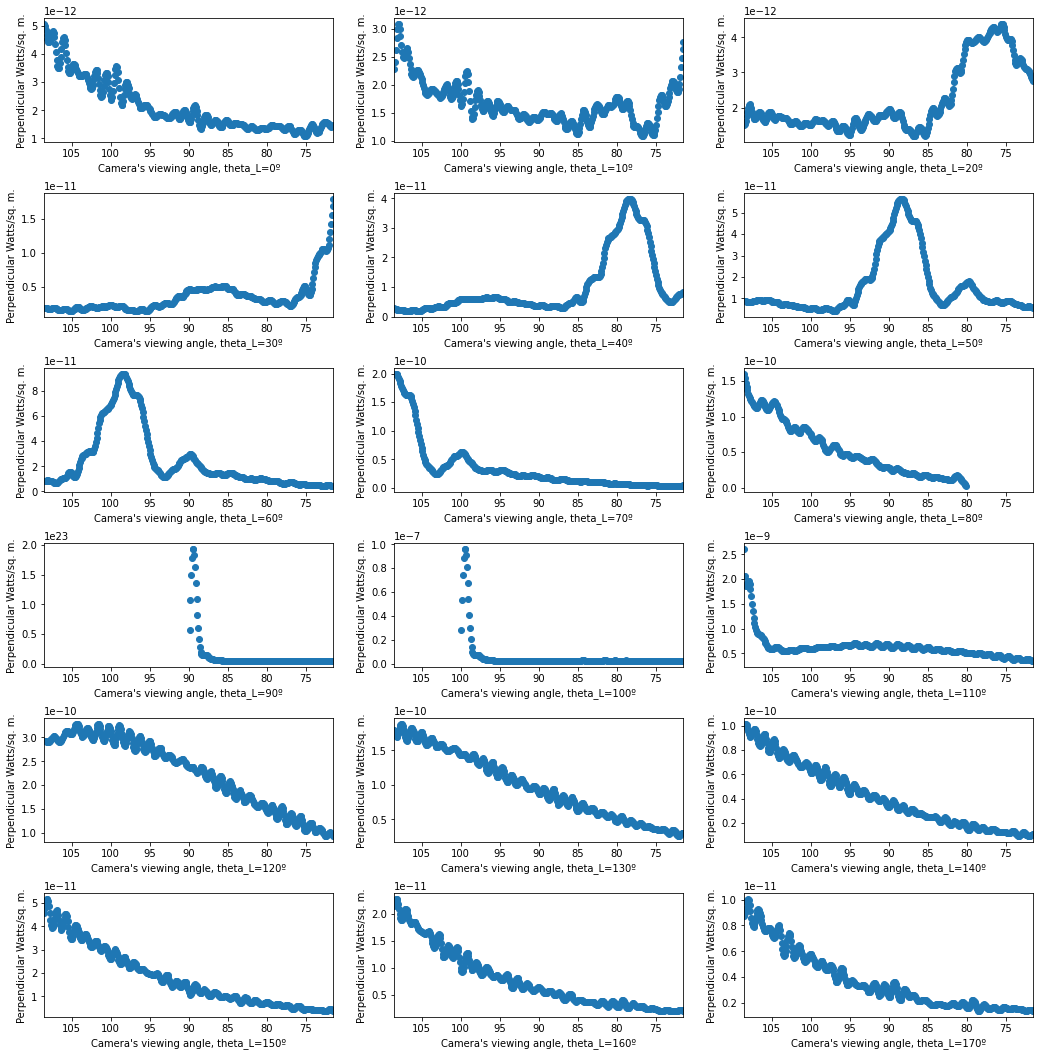

In [ ]:
# plots the intensity of light with a certain polarization vs camera's viewing angle
# shows plots for theta_L in range of (0, 170)
fig, ax = plt.subplots(6, 3, figsize=(15, 15))
fig.tight_layout(pad=3)
angle = 0
for i in range(0, 6):
    for j in range(0, 3):
        polarized_option = polarizer.s
        # theta_min = 0 # or 71.5
        # theta_max = 180 # or 108.5
        theta_min = 71.5
        theta_max = 108.5
        expected_scattering = get_expected_scattering(R=1, 
                                                      theta_L=angle, 
                                                      theta_range=(theta_min, theta_max), 
                                                      polarized=polarized_option)
        ax[i][j].set_xlim(left=theta_max, right=theta_min)
        ax[i][j].scatter(expected_scattering["Camera's theta"], 
                         expected_scattering[polarized_option])
        ax[i][j].set_xlabel("Camera's viewing angle, theta_L=" + str(angle) + "º")
        ax[i][j].set_ylabel(polarized_option)
        angle += 10
plt.savefig('intensity_v_angle') # save plot as .png file
plt.show()

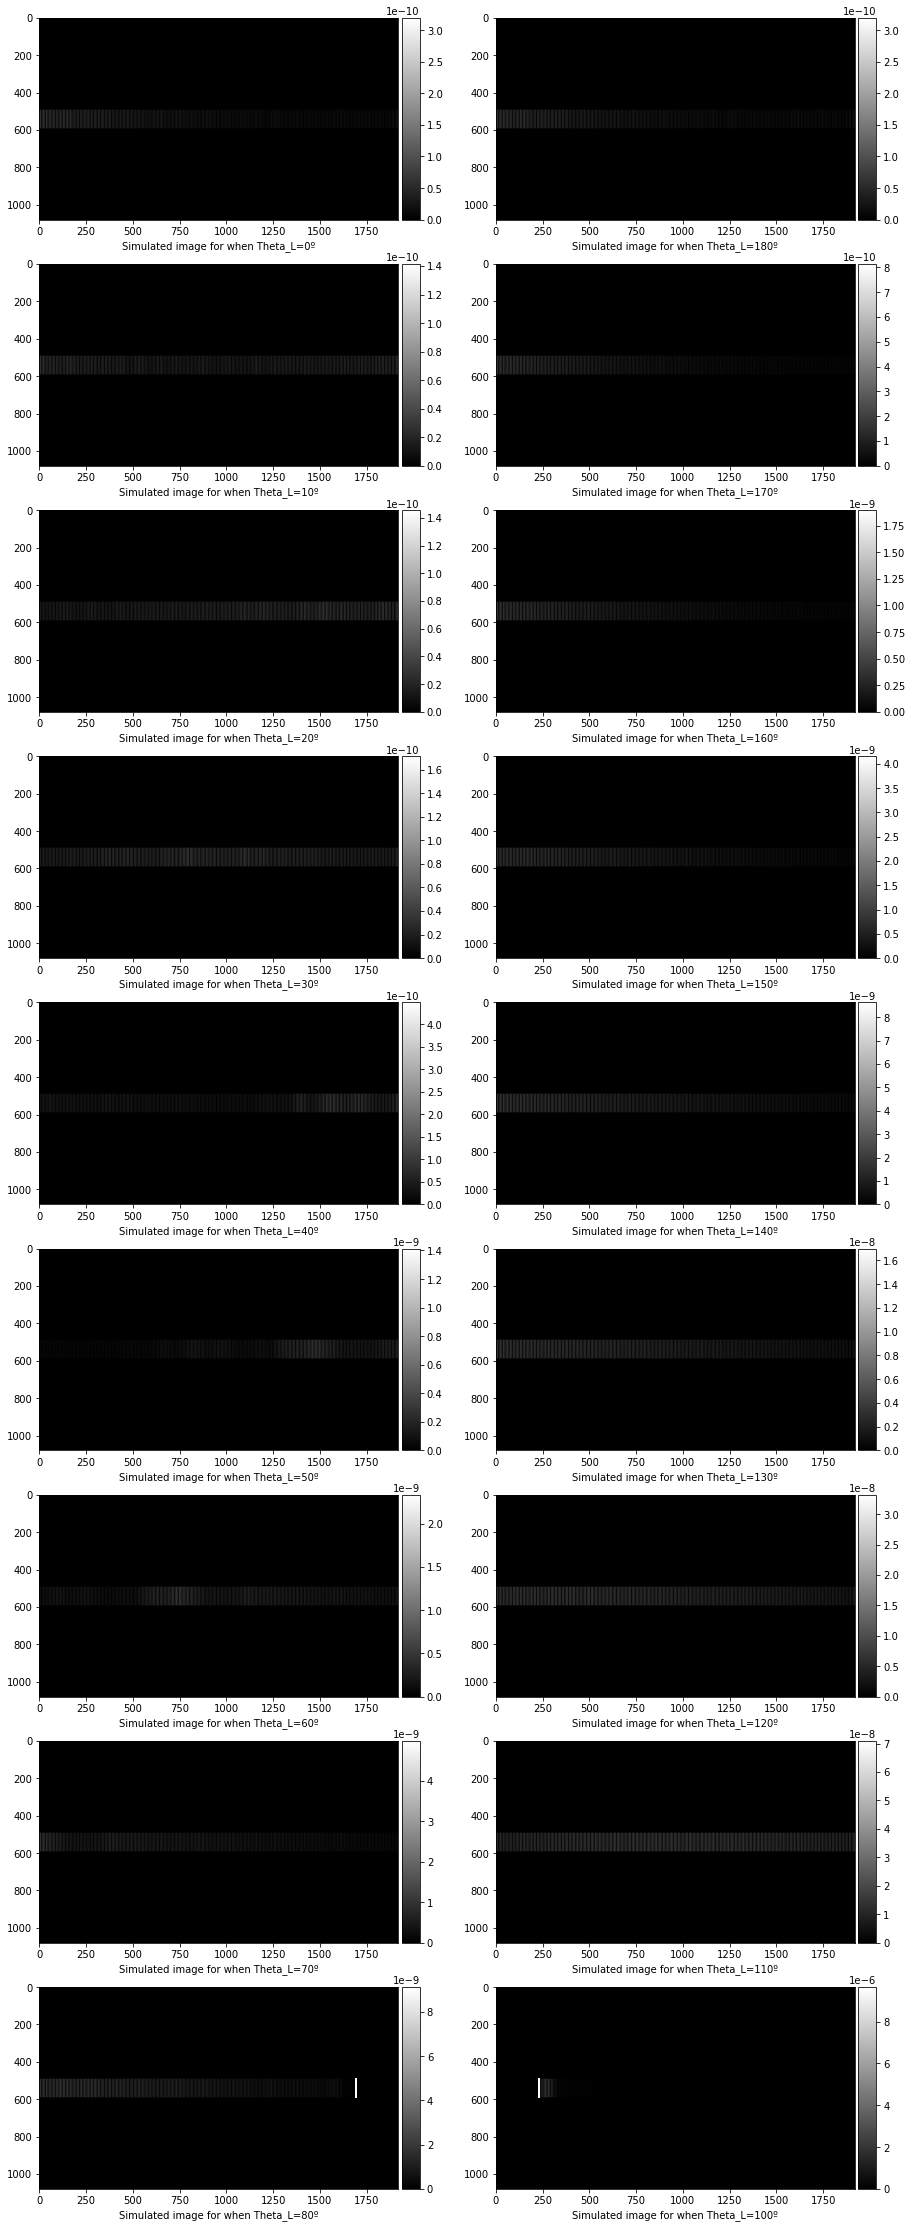

In [ ]:
# shows simulated images for theta_L in range of (0, 170)
fig, axs = plt.subplots(9, 2, figsize=(15, 40))
angle = -10
for j in range(0, 2):
    for i in range(0, 9):
        if j == 0:
            angle += 10
        elif j == 1:
            angle -= 10
        polarized_option = polarizer.p
        
        expected_scattering = get_expected_scattering(R=1, 
                                                      theta_L=angle, 
                                                      theta_range=(71.5, 108.5), 
                                                      polarized=polarized_option)
        img = get_simulated_image(expected_scattering, width_of_laser_in_pixels=100)
        ax = axs[i, j]
        img = ax.imshow(img, cmap='gray')
        ax.set_xlabel('Simulated image for when Theta_L=' + str(angle) + "º")

        # make colorbar the same height as each subplot
        # create an axes on the right side of ax. The width of cax will be 5%
        # of ax and the padding between cax and ax will be fixed at 0.05 inch.
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)  
        plt.colorbar(img, cax=cax)
    angle = 190
plt.savefig('simulated_scattering')
plt.show()

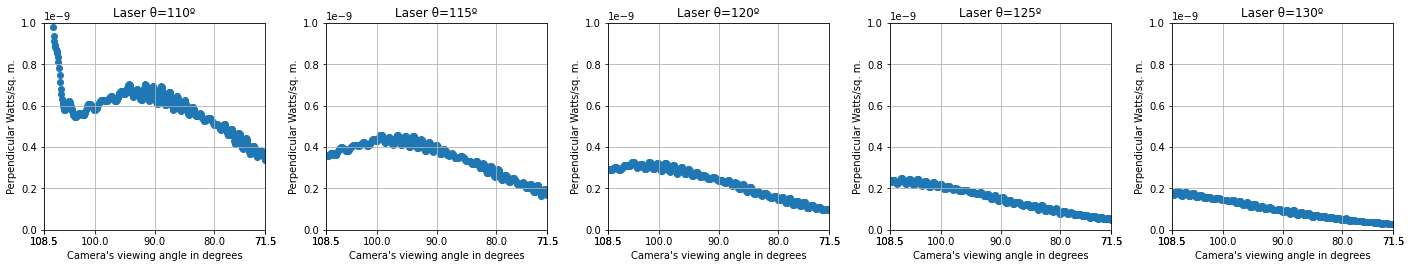

In [ ]:
# plots the intensity of light with a certain polarization vs camera's viewing angle
# shows plots for theta_L in range of (0, 170)
fig, ax = plt.subplots(1, 5, figsize=(20, 4))
fig.tight_layout(pad=3)
angle = 110

for i in range(0, 5):
    polarized_option = polarizer.s
    # theta_min = 0 # or 71.5
    # theta_max = 180 # or 108.5
    theta_min = 71.5
    theta_max = 108.5
    # theta_min = 50
    # theta_max = 130
    expected_scattering = get_expected_scattering(R=1, 
                                                  theta_L=angle, 
                                                  theta_range=(theta_min, theta_max), 
                                                  polarized=polarized_option)
    # ax[i].set_xlim(left=theta_min, right=theta_max)
    ax[i].set_xlim(right=theta_min, left=theta_max)
    ax[i].set_xticks([theta_max, 108.5, 100, 90, 80, 71.5, theta_min])
    ax[i].scatter(expected_scattering["Camera's theta"], 
                     expected_scattering[polarized_option])
    ax[i].set_title("Laser θ=" + str(angle) + "º")
    ax[i].set_xlabel("Camera's viewing angle in degrees")
    ax[i].set_ylabel(polarized_option)
    # ax[i].set_ylim(0, 3e-9)
    ax[i].set_ylim(0, 1e-9)
    # ax[i].set_yscale("log")
    ax[i].grid(True)
    angle += 5
plt.savefig('intensity_v_angle_109_72')
plt.show()

Below are the plots of the intensity of light with a certain polarization vs Horizontal Pixel Position. These graphs don't perfectly align with the graphs above since the field of view of the camera is slightly less than 37º (which was what Thorlabs stated for the lens) since we used a spacer to increase the focal length.

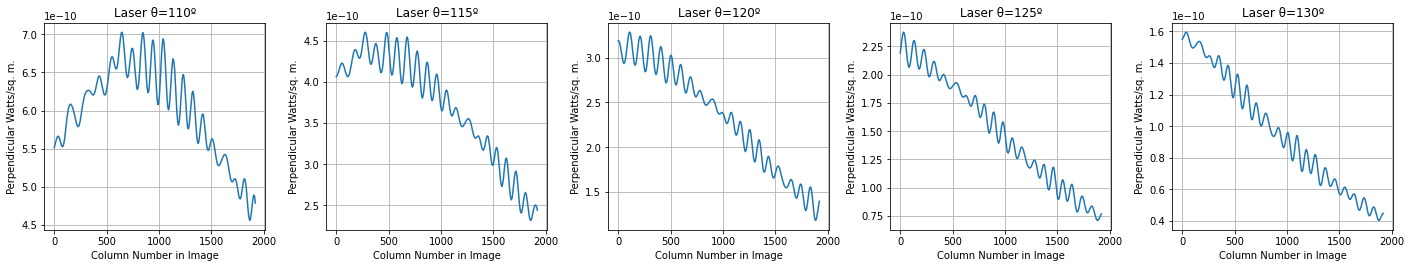

In [ ]:
# plots the intensity of light with a certain polarization vs Horizontal Pixel Position
# shows plots for theta_L in range of (0, 170)
fig, ax = plt.subplots(1, 5, figsize=(20, 4))
fig.tight_layout(pad=3)
angle = 110
sensor_width = 9.677 # mm 

for i in range(0, 5):
    polarized_option = polarizer.s
    # theta_min = 0 # or 71.5
    # theta_max = 180 # or 108.5
    theta_min = 71.5
    theta_max = 108.5
    # theta_min = 50
    # theta_max = 130
    expected_scattering = get_expected_scattering(R=1, 
                                                  theta_L=angle, 
                                                  theta_range=(theta_min, theta_max), 
                                                  polarized=polarized_option)
    expected_scattering_cut = expected_scattering[np.logical_and(expected_scattering["Camera's theta"] <= 103,
                                                        expected_scattering["Camera's theta"] >= 77)]
    ax[i].plot(expected_scattering_cut['Horizontal pixel pos'].to_numpy(),
               expected_scattering_cut[polarized_option])
    ax[i].set_title("Laser θ=" + str(angle) + "º")
    ax[i].set_xlabel("Column Number in Image")
    ax[i].set_ylabel(polarized_option)
    # ax[i].set_ylim(0, 3e-9)
    # ax[i].set_ylim(0, 1e-9)
    # ax[i].set_yscale("log")
    ax[i].grid(True)
    angle += 5
# plt.savefig('intensity_v_angle')
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


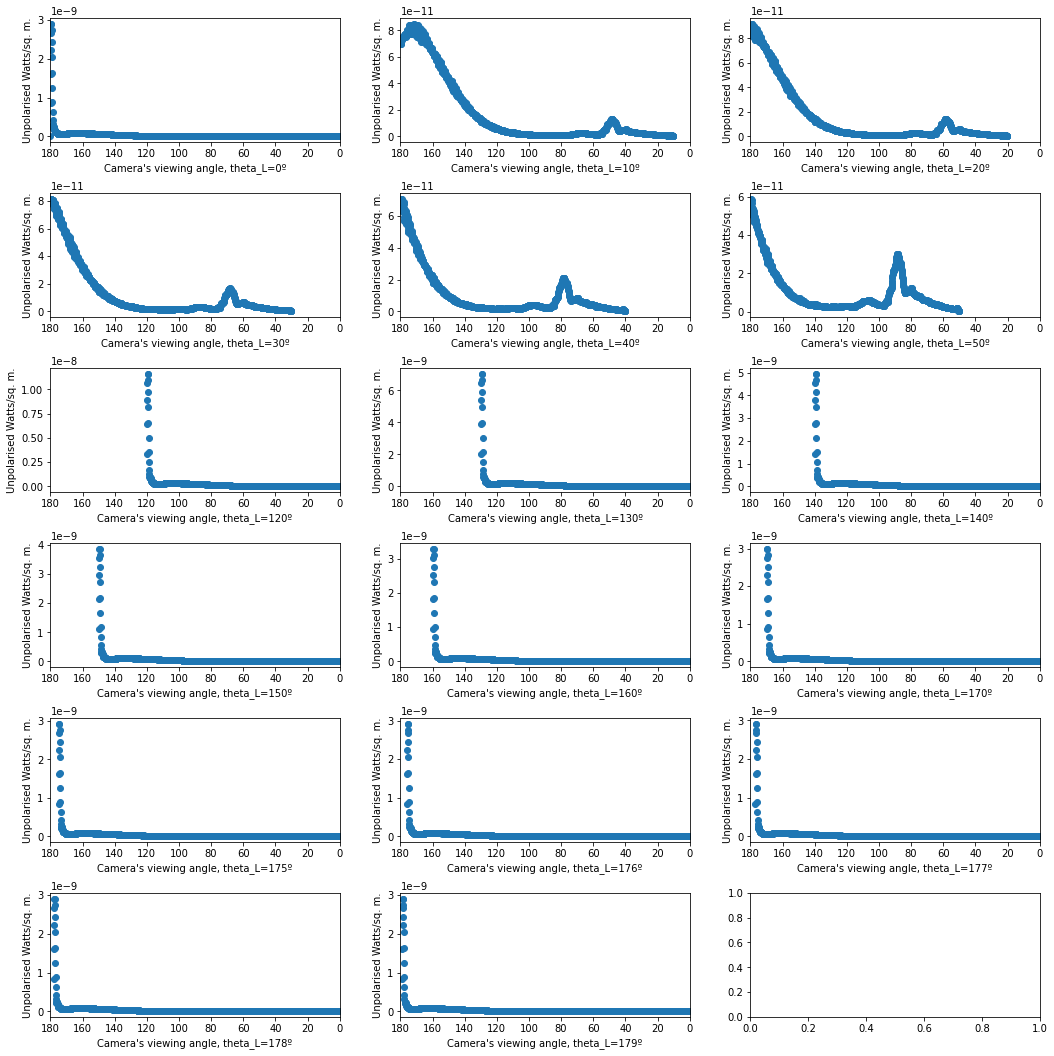

In [ ]:
# plots the intensity of light with a certain polarization vs camera's viewing angle
# shows plots for theta_L in range of (0, 170)
thetas = [0, 10, 20, 30, 40, 50, 120, 130, 140, 150, 160, 170, 175, 176, 177, 178, 179]
fig, ax = plt.subplots(6, 3, figsize=(15, 15))
fig.tight_layout(pad=3)
angle = 0
idx = 0
theta = thetas[idx]
polarized_option = polarizer.none
theta_min = 0 # or 71.5
theta_max = 180 # or 108.5
# theta_min = 71.5
# theta_max = 108.5
for i in range(0, 6):
    for j in range(0, 3):
        if idx < len(thetas):
            angle = thetas[idx]
            expected_scattering = get_expected_scattering(R=1, 
                                                        theta_L=angle, 
                                                        theta_range=(theta_min, theta_max), 
                                                        polarized=polarized_option)
            ax[i][j].set_xlim(left=theta_max, right=theta_min)
            ax[i][j].scatter(expected_scattering["Camera's theta"], 
                            expected_scattering[polarized_option])
            ax[i][j].set_xlabel("Camera's viewing angle, theta_L=" + str(angle) + "º")
            ax[i][j].set_ylabel(polarized_option)
        idx += 1
plt.savefig('intensity_v_angle_comparison') # save plot as .png file
plt.show()

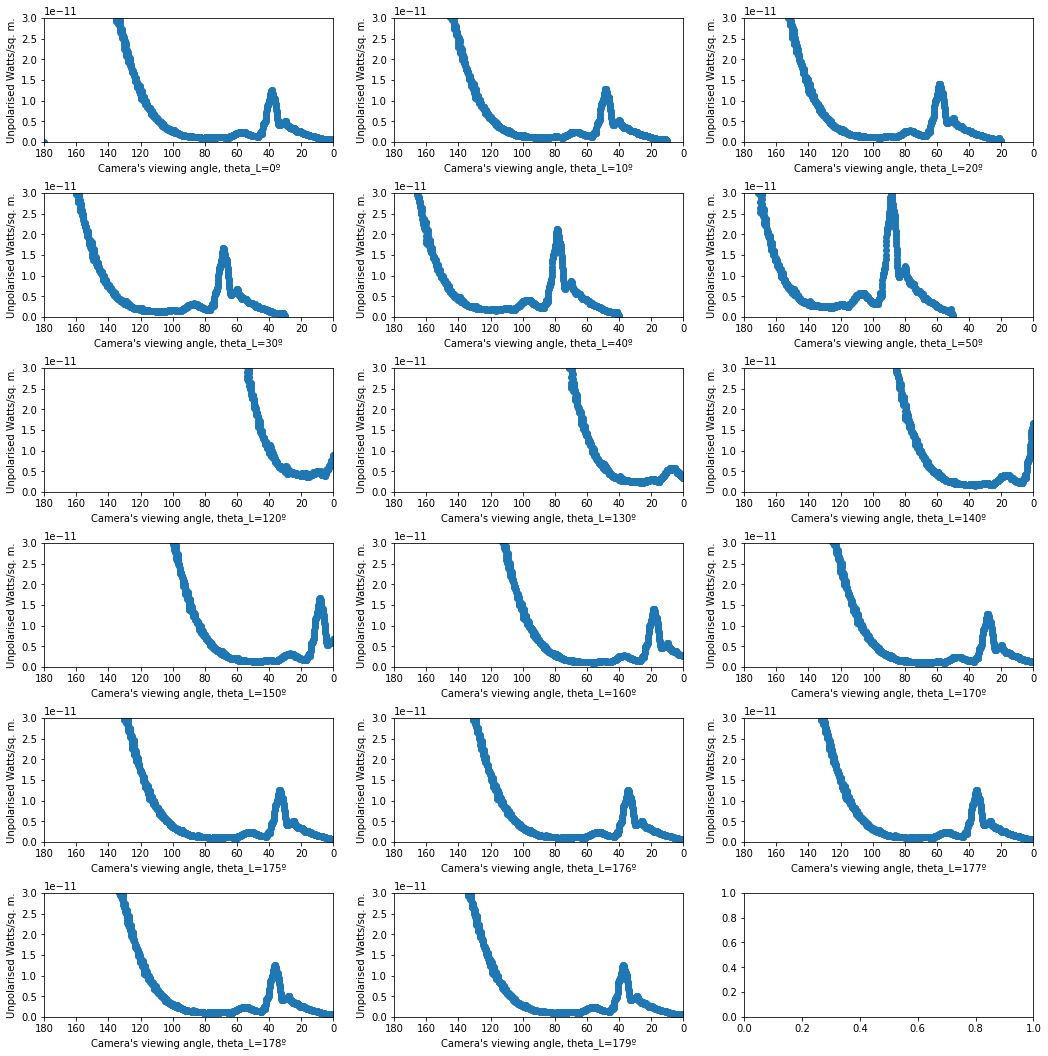

In [ ]:
# plots the intensity of light with a certain polarization vs camera's viewing angle
# shows plots for theta_L in range of (0, 170)
thetas = [0, 10, 20, 30, 40, 50, 120, 130, 140, 150, 160, 170, 175, 176, 177, 178, 179]
fig, ax = plt.subplots(6, 3, figsize=(15, 15))
fig.tight_layout(pad=3)
angle = 0
idx = 0
theta = thetas[idx]
polarized_option = polarizer.none
theta_min = 0 # or 71.5
theta_max = 180 # or 108.5
# theta_min = 71.5
# theta_max = 108.5
for i in range(0, 6):
    for j in range(0, 3):
        if idx < len(thetas):
            angle = thetas[idx]
            expected_scattering = get_expected_scattering(R=1, 
                                                        theta_L=angle, 
                                                        theta_range=(theta_min, theta_max), 
                                                        polarized=polarized_option)
            ax[i][j].set_ylim(0, 3e-11)
            ax[i][j].set_xlim(left=theta_max, right=theta_min)
            ax[i][j].scatter(expected_scattering["Camera's theta"], 
                            expected_scattering[polarized_option])
            ax[i][j].set_xlabel("Camera's viewing angle, theta_L=" + str(angle) + "º")
            ax[i][j].set_ylabel(polarized_option)
        idx += 1
plt.savefig('intensity_v_angle_comparison_same_scale') # save plot as .png file
plt.show()

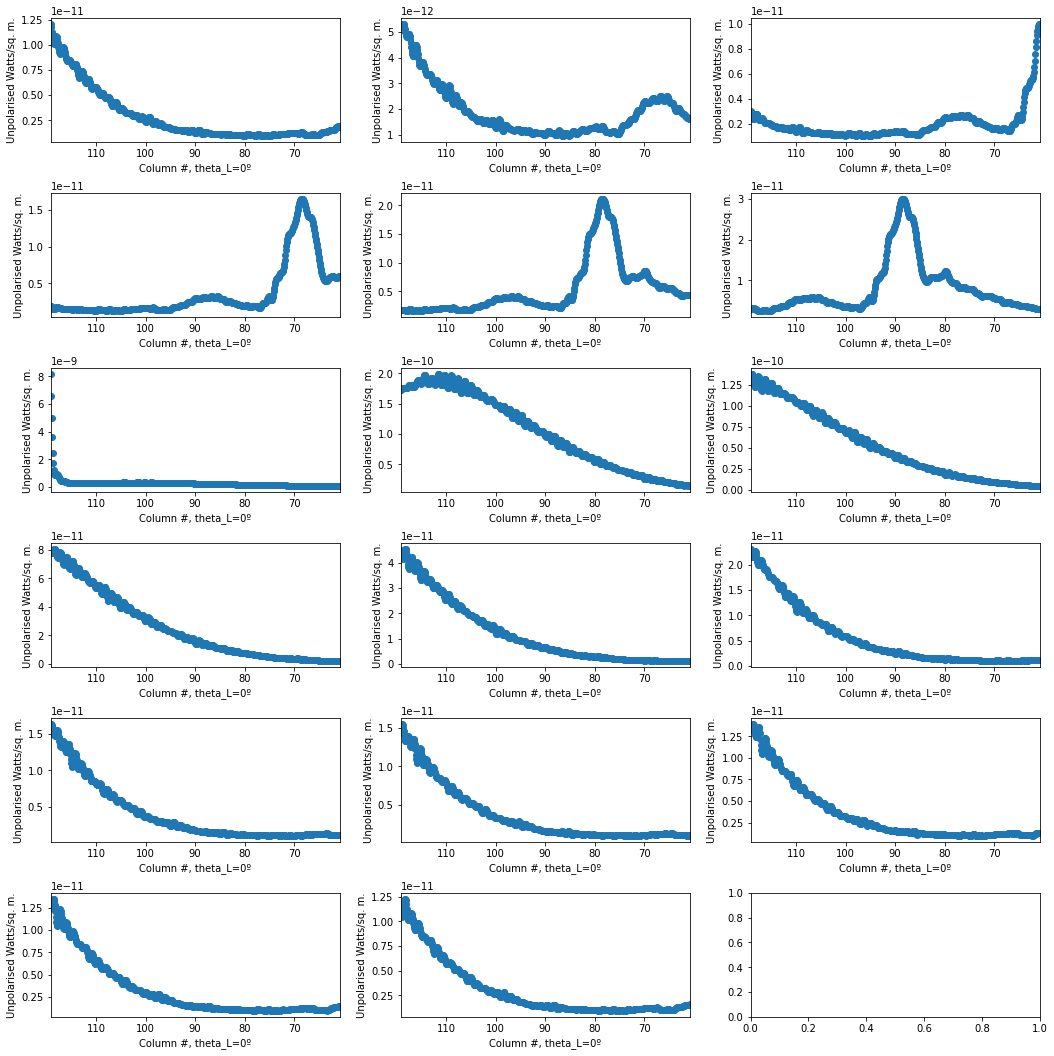

In [18]:
# plots the intensity of light with a certain polarization vs camera's viewing angle
# shows plots for theta_L in range of (0, 170)
thetas = [0, 10, 20, 30, 40, 50, 120, 130, 140, 150, 160, 170, 175, 176, 177, 178, 179]
fig, ax = plt.subplots(6, 3, figsize=(15, 15))
fig.tight_layout(pad=3)
angle = 0
idx = 0
theta = thetas[idx]
polarized_option = polarizer.none
# theta_min = 0
# theta_max = 180
theta_min = 90 - 58.3 / 2
theta_max = 90 + 58.3 / 2
for i in range(0, 6):
    for j in range(0, 3):
        if idx < len(thetas):
            angle = thetas[idx]
            expected_scattering = get_expected_scattering(R=1, 
                                                        theta_L=angle, 
                                                        theta_range=(theta_min, theta_max), 
                                                        polarized=polarized_option)
            # ax[i][j].set_ylim(0, 1e-10)
            ax[i][j].set_xlim(left=theta_max, right=theta_min)
            y = expected_scattering[polarized_option]
            ax[i][j].scatter(expected_scattering["Camera's theta"], y)
            ax[i][j].set_xlabel(f'Column #, theta_L={theta}º')
            ax[i][j].set_ylabel(polarized_option)
        idx += 1
# plt.savefig('intensity_v_angle_comparison_FOV_58') # save plot as .png file
plt.show()